In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import numpy as np

from utils import progress_bar

In [3]:
# define the model

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=False)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [4]:
# Preparing data..
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='/dev/shm', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=int(128*4), shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(
    root='/dev/shm', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = 'cpu'
lr = 0.01
epochs = 100
best_acc = 0

net = VGG('VGG11').to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True

# if args.resume:
#     # Load checkpoint.
#     print('==> Resuming from checkpoint..')
#     assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
#     checkpoint = torch.load('./checkpoint/ckpt.pth')
#     net.load_state_dict(checkpoint['net'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']
start_epoch = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0, last_epoch=-1)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        # state = {
        #     'net': net.module.state_dict(),
        #     'acc': acc,
        #     'epoch': epoch,
        # }
        # torch.save(state, './cifar_vgg_11.pth')
        best_acc = acc


# for epoch in range(start_epoch, start_epoch+epochs):
#     train(epoch)
#     test(epoch)
#     scheduler.step()

checkpoint = torch.load('./cifar_vgg_11.pth')
net.load_state_dict(checkpoint['net'])

# test(0)


<All keys matched successfully>

In [6]:
for n,m in net.named_modules():
    if n!='' and n!='features':
        print(n,m)

features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.2 ReLU()
features.3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
features.4 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.5 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.6 ReLU()
features.7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
features.8 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.9 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.10 ReLU()
features.11 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
features.12 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
features.13 ReLU()
features.14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

features.0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.2 ReLU(inplace=True)

features.3 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

features.4 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.5 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.6 ReLU(inplace=True)

features.7 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

features.8 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.9 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.10 ReLU(inplace=True)

features.11 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.12 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.13 ReLU(inplace=True)

features.14 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

features.15 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.16 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.17 ReLU(inplace=True)

features.18 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.19 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.20 ReLU(inplace=True)

features.21 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

features.22 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.23 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.24 ReLU(inplace=True)

features.25 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

features.26 BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

features.27 ReLU(inplace=True)

features.28 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

features.29 AvgPool2d(kernel_size=1, stride=1, padding=0)

classifier Linear(in_features=512, out_features=10, bias=True)

In [7]:
# class FeatureHook():
#     def __init__(self, module):
#         self.hook = module.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.r_feature = input[0]

#     def close(self):
#         self.hook.remove()
        
        
# hook_dict = {}
# for n, m in net.named_modules():
#     if n!='' and n!='features':
#         hook_dict[n] = FeatureHook(m)
        
# root_dir = '/project/kung/xin/cifar_vgg11_saved_model/'
        
# for class_idx in range(10):
#     t = np.array(trainset.targets)
#     indices = np.argwhere(t==class_idx).flatten().tolist()
#     sub_set = torch.utils.data.Subset(trainset, indices)
#     sub_loader = torch.utils.data.DataLoader(
#         sub_set, batch_size=len(sub_set), shuffle=False, num_workers=8)
#     for image, label in sub_loader:
#         output = net(image)
        
#     save_dict = {n:h.r_feature for n, h in hook_dict.items()}
#     save_dict['output'] = output
    
#     torch.save(save_dict, root_dir+'c'+str(class_idx)+'.pth')

In [8]:
import glob, os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from di import denormalize
import numpy as np

from IPython.display import HTML
import io
import base64

In [9]:

file_name = glob.glob('/project/kung/xin/cifar_vgg11_saved_model/*.pth')

In [10]:
# for class 0

saved = torch.load('/project/kung/xin/cifar_vgg11_saved_model/c0.pth')


In [36]:
class FlowLayout(object):
    ''' A class / object to display plots in a horizontal / flow layout below a cell '''
    def __init__(self):
        # string buffer for the HTML: initially some CSS; images to be appended
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 5px;
        border: 1px solid #888888;  
        }
        </style>
        """

    def add_plot(self, oAxes):
        ''' Saves a PNG representation of a Matplotlib Axes object '''
        Bio=io.BytesIO() # bytes buffer for the plot
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) # make a png of the plot in the buffer

        # encode the bytes as string using base 64 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')

    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))



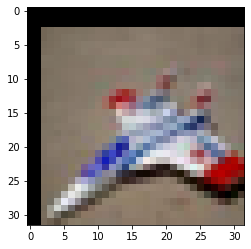

In [12]:
img_idx = 1
plt.imshow(denormalize(saved['features.0'][img_idx]).view(3,-1).T.view(32,32,3))


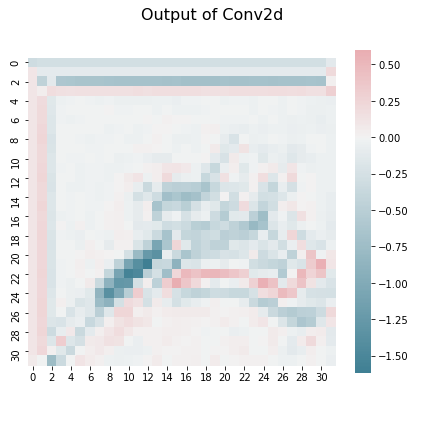
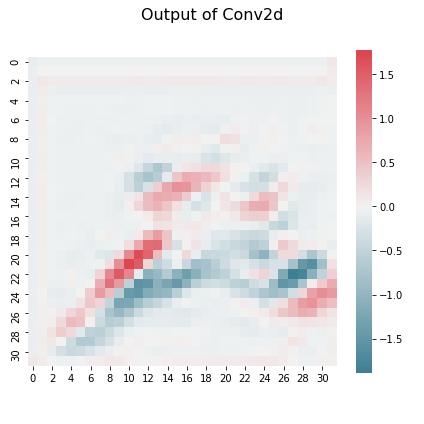
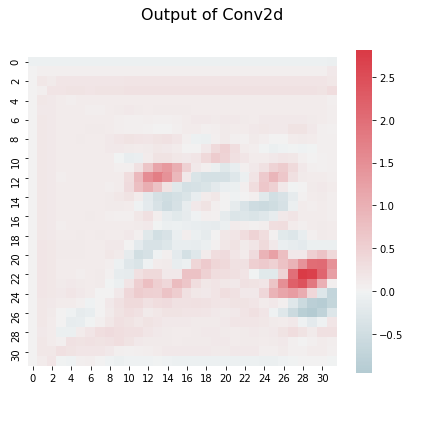
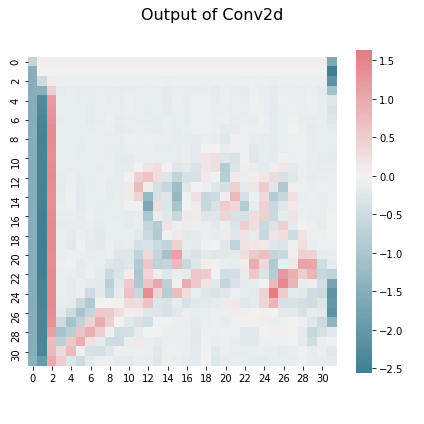

In [13]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(saved['features.1'][img_idx].detach()[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of Conv2d', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


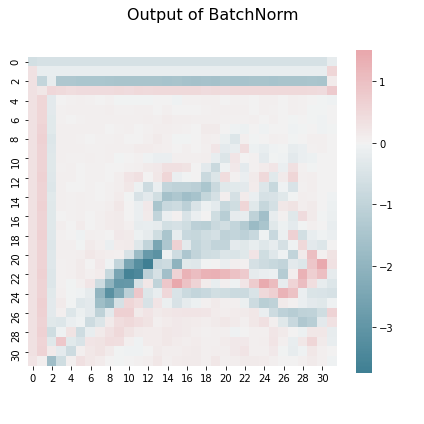
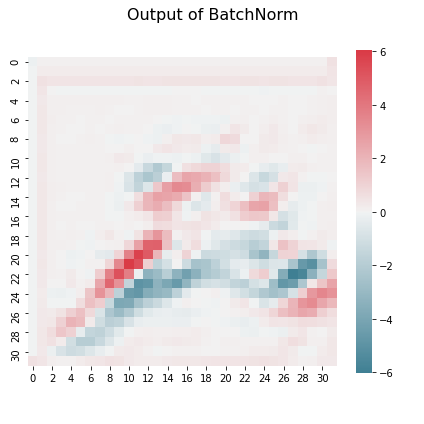
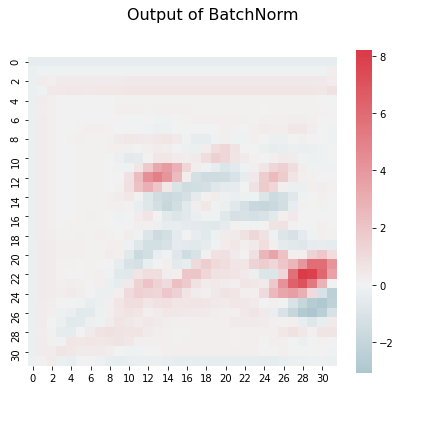
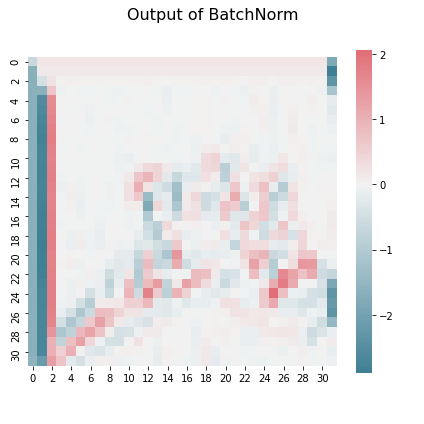

In [14]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(saved['features.2'][img_idx].detach()[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of BatchNorm', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


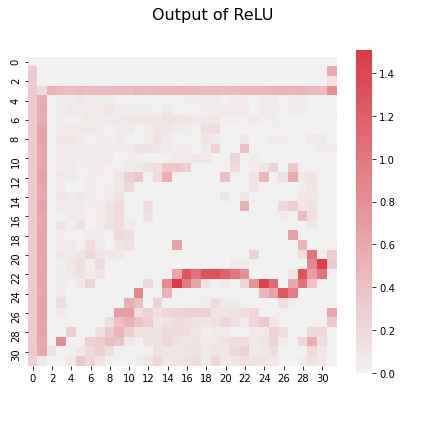
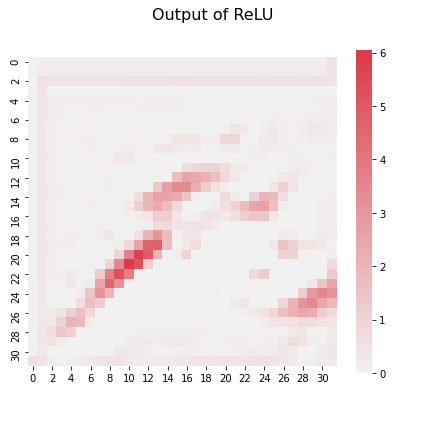
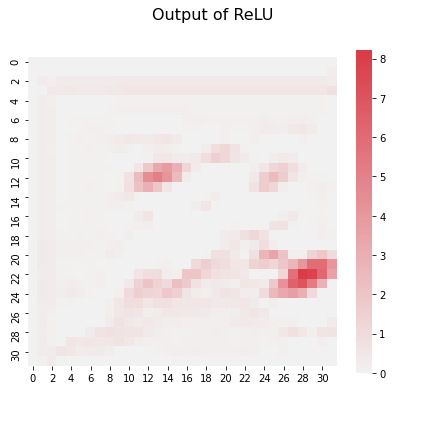
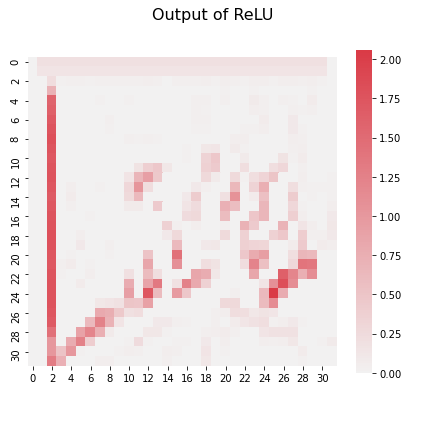

In [15]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(saved['features.3'][img_idx].detach()[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of ReLU', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()

In [16]:
def pool_and_unpool(tensor):
    tensor = tensor[None,:,:,:]
    inp_size = tensor.size()
    out, idx = F.max_pool2d(input=tensor, kernel_size=2, return_indices=True)
    return F.max_unpool2d(input=out, indices=idx, kernel_size=2, output_size=inp_size)[0]

def pool(tensor):
    tensor = tensor[None,:,:,:]
    out, idx = F.max_pool2d(input=tensor, kernel_size=2, return_indices=True)
    return out[0], idx

## Inverse `ReLU` and `BatchNorm` Together


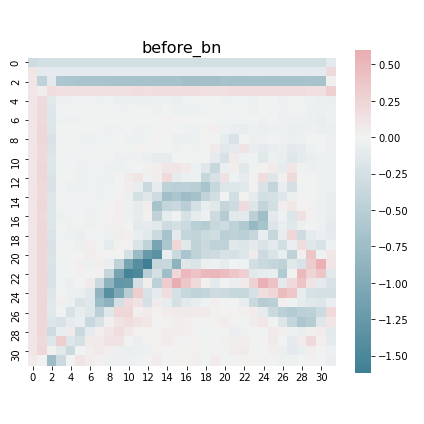
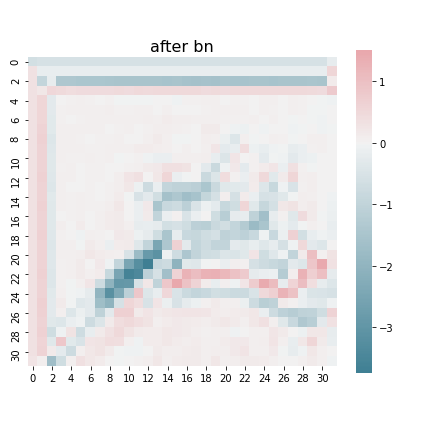
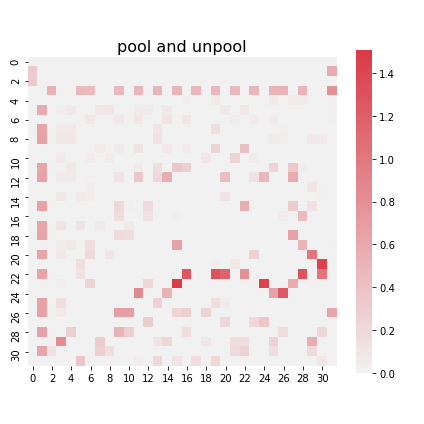
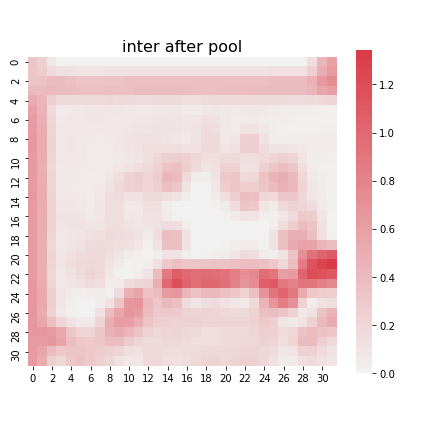
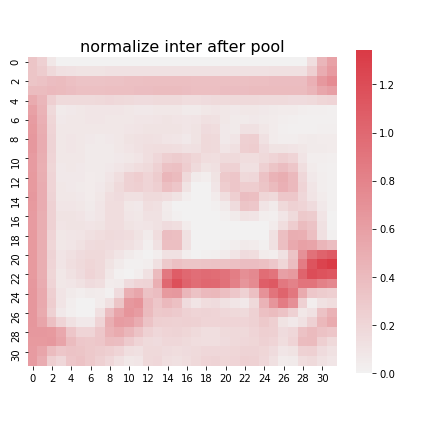
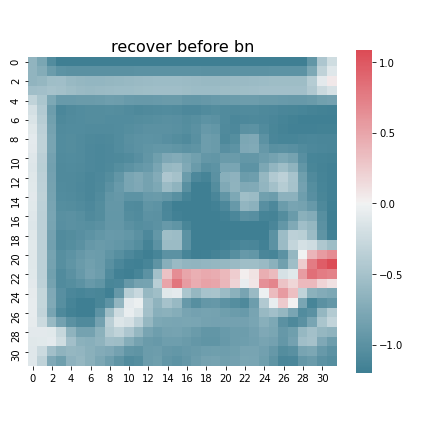

In [49]:
before_bn = saved['features.1'][img_idx].detach()[0]

target = saved['features.2'][img_idx].detach()[0]

mean_target = target.mean()
std_target  = target.std(unbiased=False)

# interpolate the maxpooling result
t_out, pos_idx = pool(saved['features.3'][img_idx].detach())
t_pool_unpool = pool_and_unpool(saved['features.3'][img_idx].detach())[0]
interp = F.interpolate(t_out[None,:,:,:], size=None, scale_factor=2, mode='bilinear', align_corners=None, recompute_scale_factor=None)[0][0]

mean_interp = interp.mean()
std_interp = interp.std(unbiased=False)
# shift_interp = (interp-mean_interp)/std_interp
shift_interp = interp

std_beforebn = before_bn.std(unbiased=False)
mean_beforebn = before_bn.mean()


running_mean = net.features[1].running_mean[0]
running_std  = torch.sqrt(net.features[1].running_var[0])

recov_interp = shift_interp*1.7 - 1.2



oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib

for i in range(6): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    if i==0:
        plot_me = before_bn
        name='before_bn'
    elif i==1:
        plot_me = target
        name='after bn'
    elif i==2:
        plot_me = t_pool_unpool
        name='pool and unpool'
    elif i==3:
        plot_me = interp
        name='inter after pool'
    elif i==4:
        plot_me = shift_interp
        name='normalize inter after pool'
    elif i==5:
        plot_me = recov_interp
        name='recover before bn'
    
    sns.heatmap(plot_me, ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    ax.set_title(name, fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


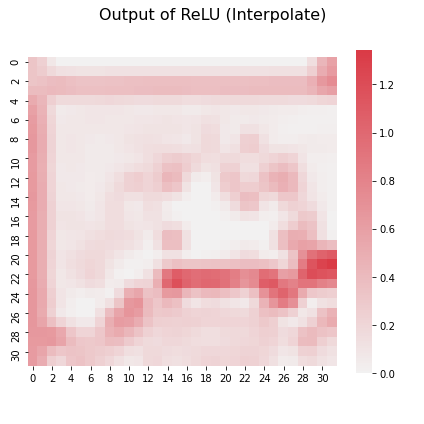
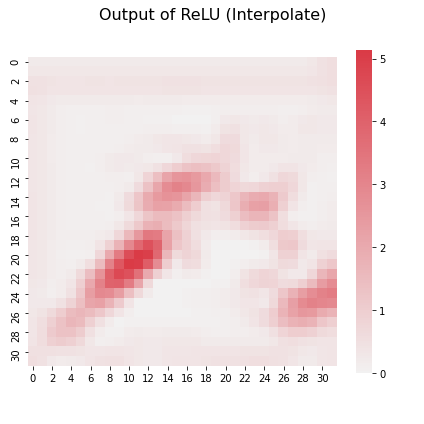
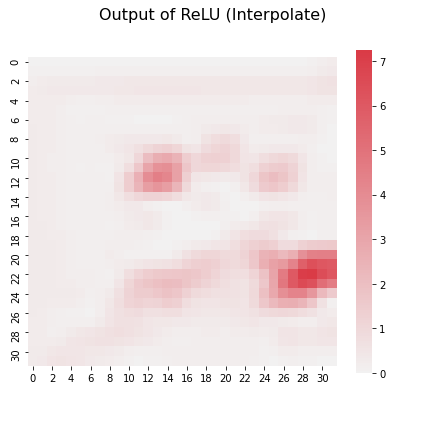
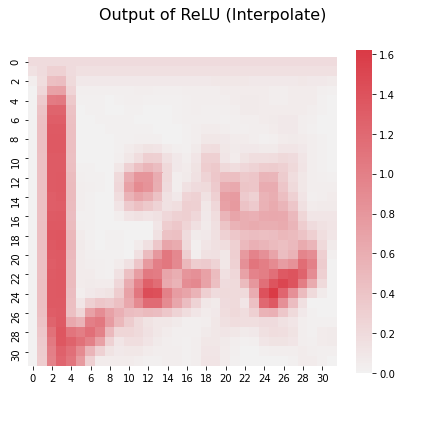

In [24]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    t_out, _ = pool(saved['features.3'][img_idx].detach())
    t_out = F.interpolate(t_out[None,:,:,:], size=None, scale_factor=2, mode='bilinear', align_corners=None, recompute_scale_factor=None)[0]
    sns.heatmap(t_out[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of ReLU (Interpolate)', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


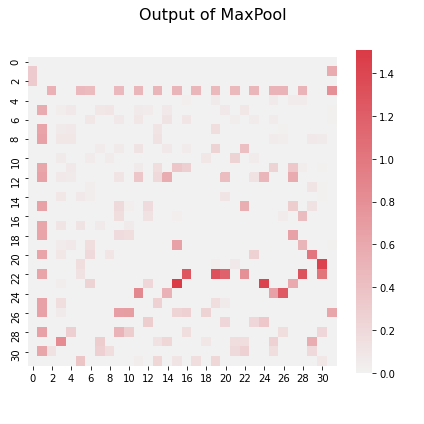
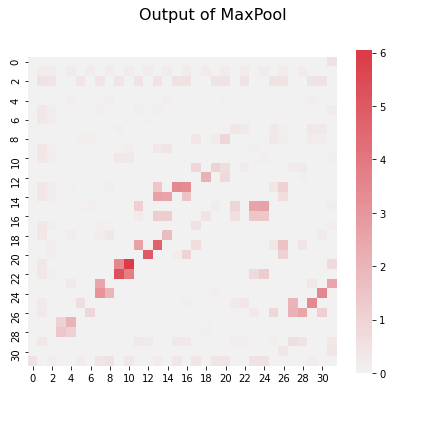
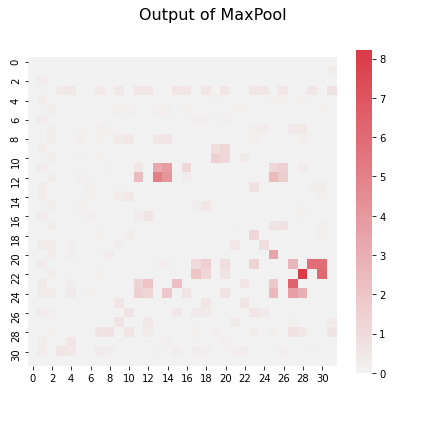
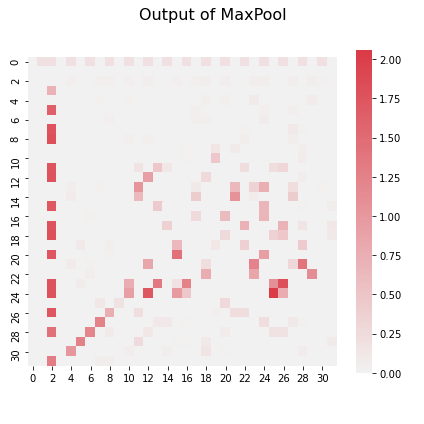

In [18]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    t_out = pool_and_unpool(saved['features.3'][img_idx].detach())
    sns.heatmap(t_out[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of MaxPool', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


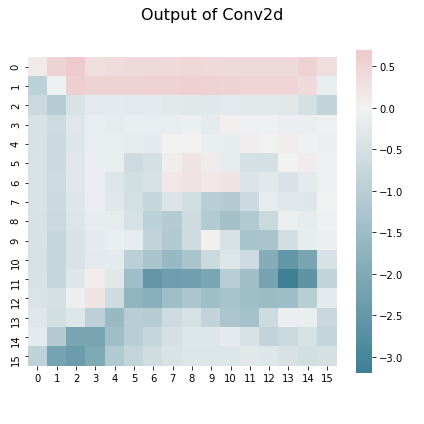
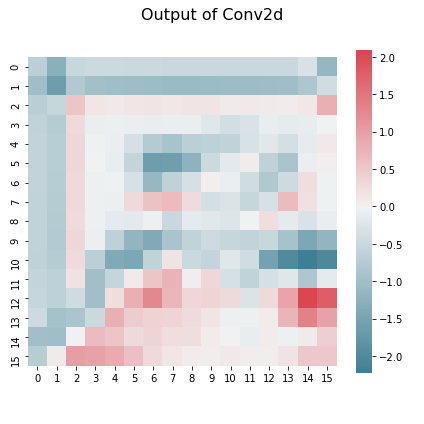
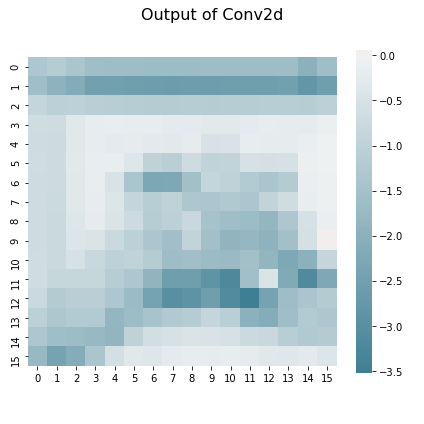
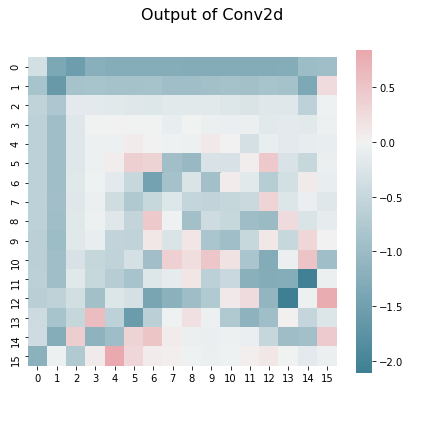

In [19]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(saved['features.5'][img_idx].detach()[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of Conv2d', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


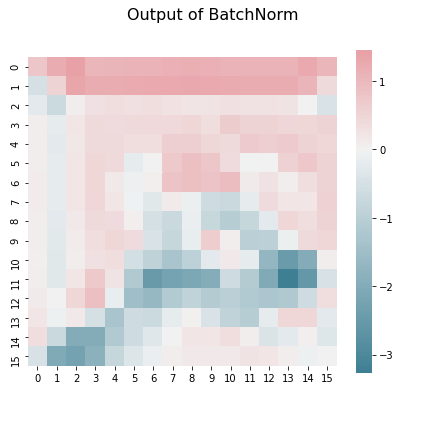
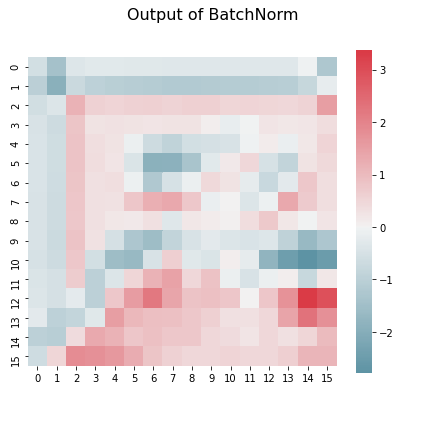
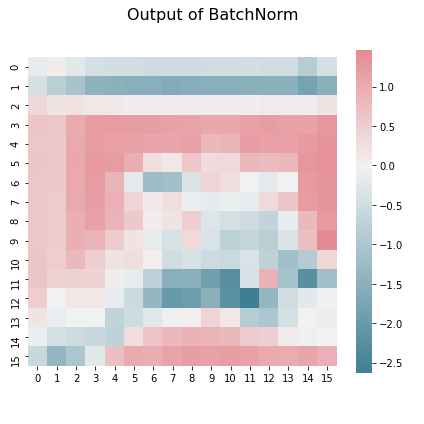
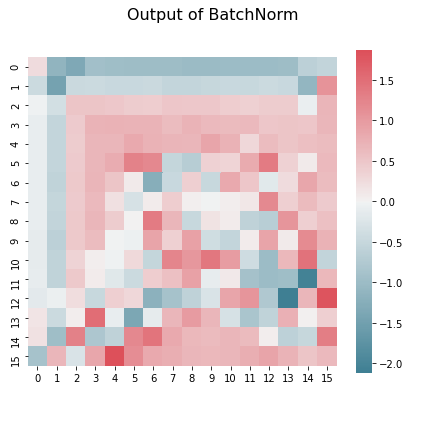

In [20]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(saved['features.6'][img_idx].detach()[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of BatchNorm', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


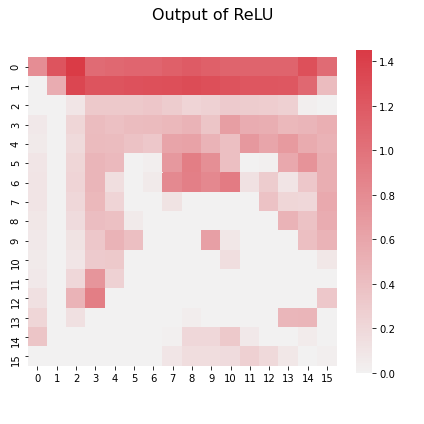
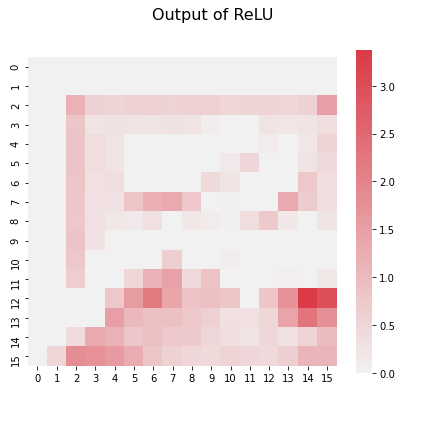
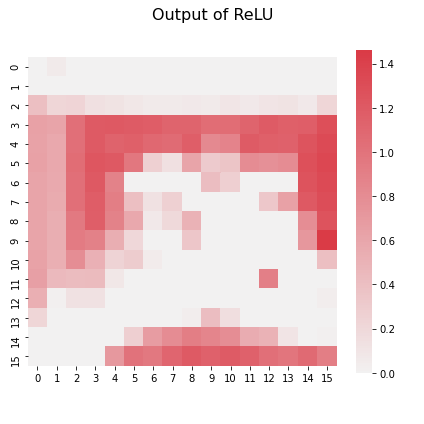
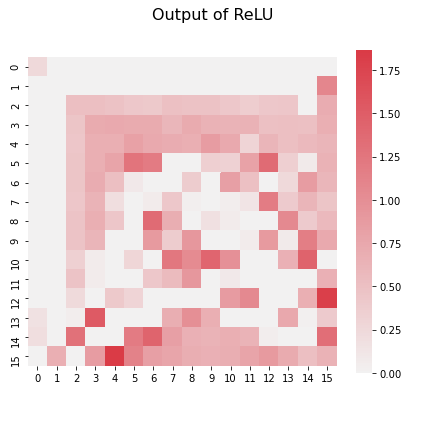

In [21]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    t_out = saved['features.7'][img_idx].detach()
    sns.heatmap(t_out[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of ReLU', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


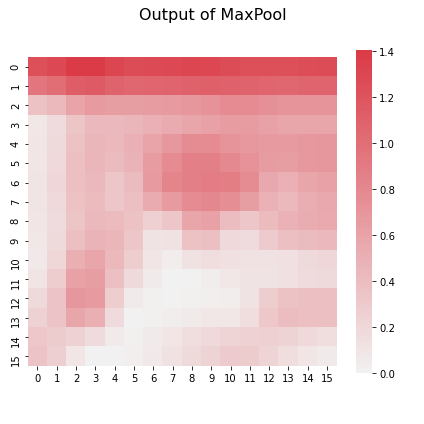
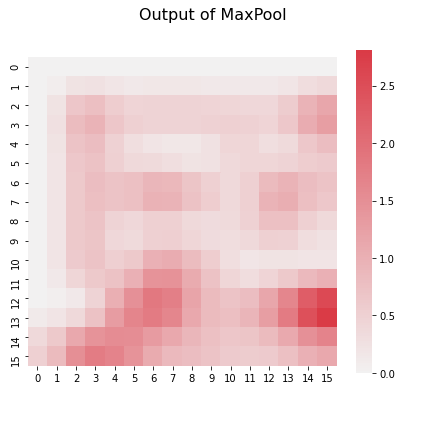
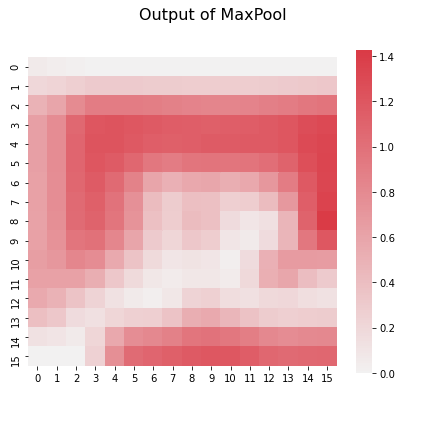
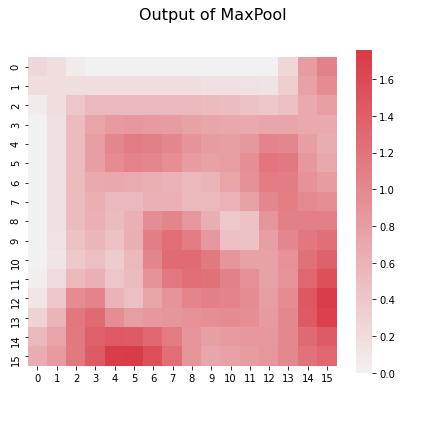

In [22]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    t_out, _ = pool(saved['features.7'][img_idx].detach())
    t_out = F.interpolate(t_out[None,:,:,:], size=None, scale_factor=2, mode='bilinear', align_corners=None, recompute_scale_factor=None)[0]
    sns.heatmap(t_out[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of MaxPool', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell


oPlot.PassHtmlToCell()


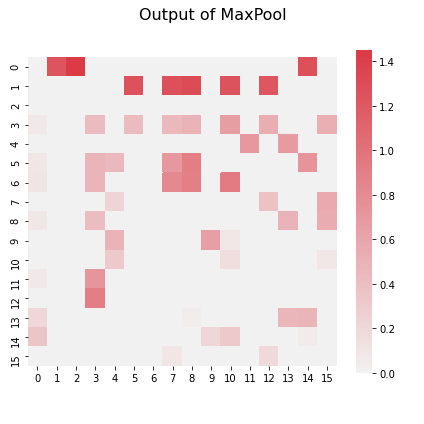
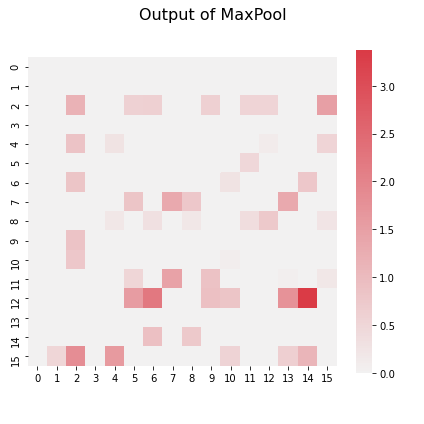
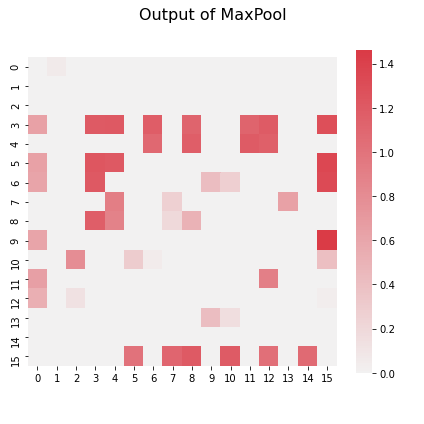
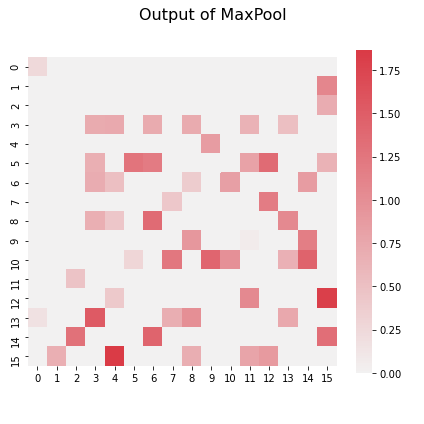

In [23]:
oPlot = FlowLayout() # create an empty FlowLayout

# Some fairly regular plotting from Matplotlib
gX = np.linspace(-5,5,100) # just used in the plot example
for i in range(4): # plot 10 charts
    fig, ax = plt.subplots(1, 1, figsize=(5.9,5.9)) # same size plots
                           # figsize=(3+i/3,2+i/4)) # different size plots
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    t_out = pool_and_unpool(saved['features.7'][img_idx].detach())
    sns.heatmap(t_out[i], ax=ax, cmap=cmap, square=True, cbar_kws={"shrink": .8}, center=0.)
    fig.tight_layout()
    fig.suptitle('Output of MaxPool', fontsize=16)
    oPlot.add_plot(ax) # pass it to the FlowLayout to save as an image
    plt.close() # this gets rid of the plot so it doesn't appear in the cell

oPlot.PassHtmlToCell()